## Train CFM

### 1. Forward transport SB1->SB2

In [40]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs

configs = Configs(# data:
                  DATA = 'LHCOlympics',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 
                  cuts_sideband_low = {'mjj': [2900, 3300]},  
                  cuts_sideband_high = {'mjj': [3700, 4100]}, 
                  preprocess = ['normalize'],
                  dim_input = 5,
                  num_dijets = 66650,  
                  # training params:   
                  DEVICE = 'cuda:1',
                  EPOCHS = 100,
                  batch_size = 512,
                  print_epochs = 20,
                  early_stopping = 30,
                  min_epochs = 200,
                  exchange_target_with_source = False,
                  data_split_fracs = [0.9, 0.1, 0.0],
                  lr = 5e-4,
                  optimizer = 'Adam',
                  fix_seed = 12234,
                  # model params:
                  MODEL = 'MLP_fwd',
                  dim_hidden = 256,
                  num_layers = 3,
                  sigma = 0.0,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 1000
                )

configs.set_workdir(path='../../results', save_config=True)

#=========================================================================================
INFO: created directory: ../../results/LHCOlympics.CondFlowMatch.MLP_fwd.2023.11.19_23h54
#=========================================================================================
+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympics                                                              |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input                   | 5                                                     

In [39]:
lhco_fwd.target.shape

torch.Size([66650, 5])

In [41]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

import torch
import numpy as np
import matplotlib.pyplot as plt

lhco_fwd = LHCOlympicsHighLevelDataset(configs)
cfm_fwd  = DynGenModelTrainer(dynamics = OptimalTransportFlowMatching(configs),
                         model = MLP(configs), 
                         dataloader = LHCOlympicsDataLoader(lhco_fwd , configs), 
                         configs = configs)

#...train model:

cfm_fwd.train()

/home/df630/DynGenModels/src/DynGenModels/datamodules/lhco/dataprocess.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(self.features[:self.num_dijets])
number of training parameters: 134661
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.9/0.1/0.0
INFO: train size: 59985, validation size: 6665, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	Epoch: 1, train loss: 0.004551050651786943, valid loss: 0.0063555866945534945  (min valid loss: 0.006309272721409796)
	Epoch: 21, train loss: 0.0044047898332730435, valid loss: 0.006213237065821886  (min valid loss: 0.006213237065821886)
	Epoch: 41, train loss: 0.004382203242315328, valid loss: 0.006237410274999482  (min valid loss: 0.006175560377804297)
	Epoch: 61, train loss: 0.004381752273036264, valid loss: 0.006182885562468852  (min valid loss: 0.006167320318387024)
	Epoch: 81, train loss: 0.004380387269844442, valid loss: 0.006210554407776467  (min valid loss: 0.006167320318387024)


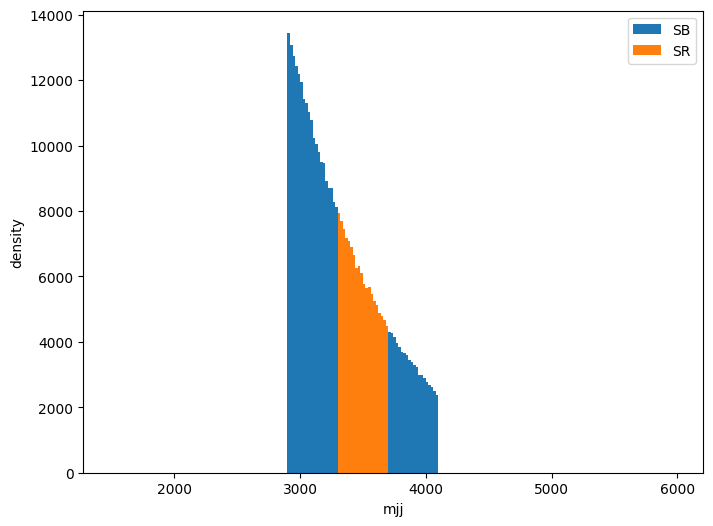

In [24]:
# histogram for featrue:

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(lhco_fwd.sidebands[...,0], bins=np.arange(1500, 6000, 20), density=False, label='SB')  
ax.hist(lhco_fwd.background[...,0], bins=np.arange(1500, 6000, 20), density=False, label='SR')  
ax.set_xlabel('mjj')
ax.set_ylabel('density')
ax.legend()
plt.show()

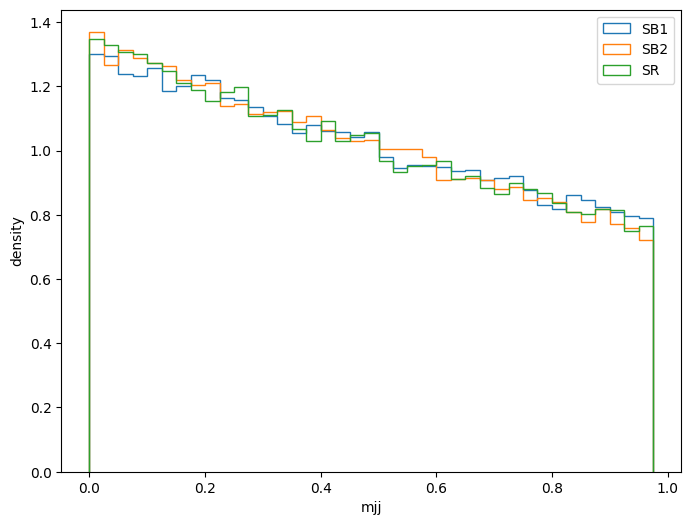

In [64]:
# histogram for featrue:

bins=np.arange(0, 1, 0.025)
log=False
n=0

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(lhco_fwd.source_preprocess[...,n], bins=bins, histtype='step' , density=True, log=log, label='SB1') 
ax.hist(lhco_fwd.target_preprocess[...,n], bins=bins, histtype='step', density=True,  log=log,label='SB2')  
ax.hist(lhco_fwd.background_preprocess[...,n], bins=bins, histtype='step', density=True,  log=log,label='SR')  
ax.set_xlabel('mjj')
ax.set_ylabel('density')
ax.legend()
plt.show()

INFO: neural ODE solver with midpoint method and steps=1000


/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


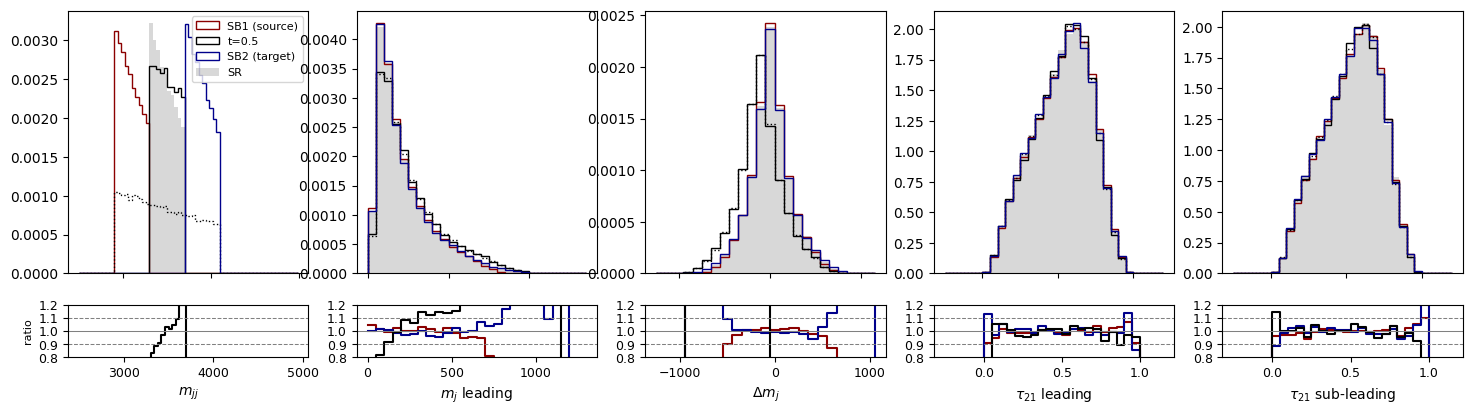

In [77]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PostProcessLHCOlympicsHighLevelData

pipeline_fwd = FlowMatchPipeline(trained_model=cfm_fwd, 
                                 configs=configs, 
                                 postprocessor=PostProcessLHCOlympicsHighLevelData,
                                 best_epoch_model=True)

pipeline_fwd.generate_samples(input_source=lhco_fwd.source_preprocess)

from utils import plot_interpolation

plot_interpolation(lhco_fwd, 
                   pipeline_fwd, 
                   figsize=(18,4.5),
                   mass_window=[configs.cuts_sideband_low['mjj'][1], configs.cuts_sideband_high['mjj'][0]], 
                   bins=[(2500, 5000, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                   log=False, 
                   density=True)

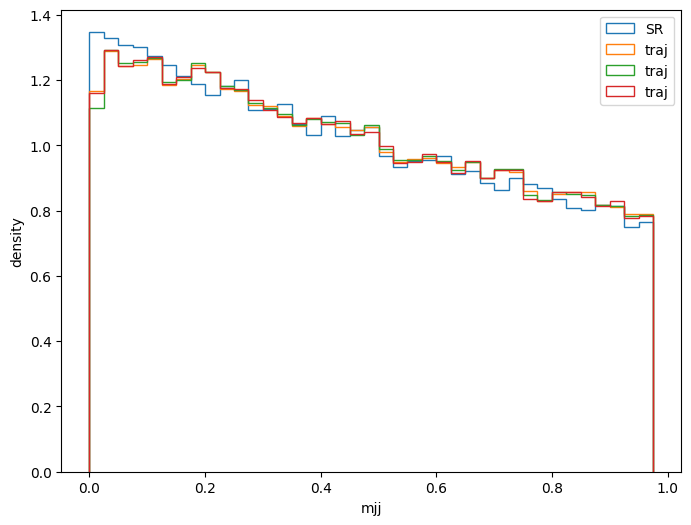

In [68]:
# histogram for featrue:

bins=np.arange(0, 1, 0.025)
log=False
n=0

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(lhco_fwd.background_preprocess[...,n], bins=bins, histtype='step', density=True,  log=log,label='SR')  
ax.hist(pipeline_fwd.trajectories[250][...,n], bins=bins, histtype='step', density=True,  log=log,label='traj')  
ax.hist(pipeline_fwd.trajectories[500][...,n], bins=bins, histtype='step', density=True,  log=log,label='traj')  
ax.hist(pipeline_fwd.trajectories[750][...,n], bins=bins, histtype='step', density=True,  log=log,label='traj')  
ax.set_xlabel('mjj')
ax.set_ylabel('density')
ax.legend()
plt.show()

### 2. Backward transport SB2->SB1

In [6]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs

configs = Configs(# data:
                  DATA = 'LHCOlympics',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 
                  cuts_sideband_low = {'mjj': [2700, 3300]},  
                  cuts_sideband_high = {'mjj': [3700, 4300]}, 
                  preprocess = ['standardize'],
                  dim_input = 5,
                  num_dijets = 1000000,  
                  # training params:   
                  DEVICE = 'cuda:1',
                  EPOCHS = 100,
                  batch_size = 512,
                  print_epochs = 20,
                  early_stopping = 30,
                  min_epochs = 200,
                  exchange_target_with_source = True,
                  data_split_fracs = [0.9, 0.1, 0.0],
                  lr = 5e-4,
                  optimizer = 'Adam',
                  fix_seed = 12234,
                  # model params:
                  MODEL = 'MLP_bwd',
                  dim_hidden = 256,
                  num_layers = 3,
                  sigma = 0.0,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 1000
                )

configs.set_workdir(path='../../results', save_config=True)

#=========================================================================================
INFO: created directory: ../../results/LHCOlympics.CondFlowMatch.MLP_bwd.2023.11.14_19h56
#=========================================================================================
+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympics                                                              |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input                   | 5                                                     

In [ ]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco_bwd = LHCOlympicsHighLevelDataset(configs, exchange_target_with_source=True)
cfm_bwd = DynGenModelTrainer(dynamics = OptimalTransportFlowMatching(configs),
                         model = MLP(configs), 
                         dataloader = LHCOlympicsDataLoader(lhco_bwd, configs), 
                         configs = configs)

#...train model:

cfm_bwd.train()

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_bwd = FlowMatchPipeline(trained_model=cfm_bwd, 
                             configs=configs, 
                             best_epoch_model=True)

pipeline_bwd.generate_samples(input_source=lhco_bwd.target)

from utils import plot_interpolation

plot_interpolation(lhco_bwd, 
                   pipeline_bwd, 
                   figsize=(18,4.5),
                   mass_window=[configs.cuts_sideband_low['mjj'][1], configs.cuts_sideband_high['mjj'][0]], 
                   bins=[(2500, 5000, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                   log=False, 
                   density=True)

# Sample from Pretrained CFM

Load a previsoiusly trained model that was stored somewhere in a directory. The directory must contain the follwing files:
- `config.json` file with all the parameters used during the training.
- `best_epoch_model.pth` model file corresponding the trained model that had the lowest validation loss.
- `last_epoch_model.pth` model file corresponding the last epoch trained model.


### Load pre-trained model and generate samples

### Optimal Transport

2023-11-13 12:12:36.522288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 12:12:37.134767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


+---------------------+--------------------------------------------------------------------------+
| Parameters          | Values                                                                   |
+---------------------+--------------------------------------------------------------------------+
| DATA                | LHCOlympics                                                              |
| dataset             | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features            | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input           | 5                                                                        |
| preprocess          |                                                                          |
| cuts_sideband_low   | mjj: [2600, 3200]                                                        |
| cuts_sideband_high  | mjj: [3800, 4400]                                                        |
| num_dije

/home/df630/DynGenModels/src/DynGenModels/datamodules/lhco/datasets.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  dijets = torch.Tensor(f['jet features'])
/home/df630/DynGenModels/src/DynGenModels/datamodules/lhco/dataprocess.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(self.features[:self.num_dijets])


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.85/0.15/0.0
INFO: train size: 63891, validation size: 11274, testing sizes: 0
+---------------------+--------------------------------------------------------------------------+
| Parameters          | Values                                                                   |
+---------------------+--------------------------------------------------------------------------+
| DATA                | LHCOlympics                                                              |
| dataset             | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features            | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input           | 5                                                                        |
| preprocess          |                                                                          |
| cuts_sideband_low   | mjj: [2600, 3200]                      

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: neural ODE solver with midpoint method and steps=1000


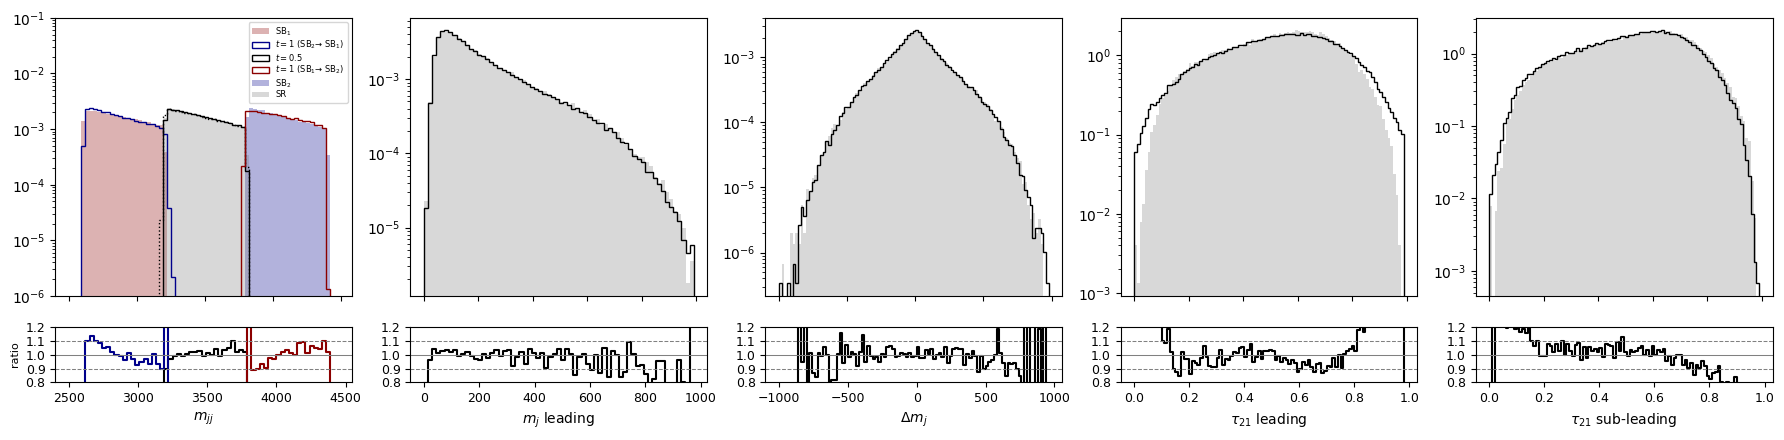

In [2]:
from utils import load_bridge_pipelines
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching

model_fwd = '../../results/LHCOlympics.OptimalTransportFlowMatching.MLP_forward.2023.11.11_22h19'
model_bwd = '../../results/LHCOlympics.OptimalTransportFlowMatching.MLP_backward.2023.11.11_23h45'

pipe_fwd, pipe_bwd, lhco_fwd, lhco_bwd = load_bridge_pipelines(model_fwd, 
                                                               model_bwd, 
                                                               bridge=OptimalTransportFlowMatching, 
                                                               device='cuda:2')

from utils import plot_interpolation_combined

plot_interpolation_combined(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(18, 4.5),
                            mass_window=[3200, 3800], 
                            bins=[(2500, 4500, 30), (0, 1000, 15), (-1000, 1000, 20), (0, 1, 0.01), (0, 1., 0.01)], 
                            log=True, 
                            density=True,
                            save_path_fwd=model_fwd + '/interpolation_combined.png',
                            save_path_bwd=model_bwd+ '/interpolation_combined.png')


### Schrodinger Bridge

+---------------------+--------------------------------------------------------------------------+
| Parameters          | Values                                                                   |
+---------------------+--------------------------------------------------------------------------+
| DATA                | LHCOlympics                                                              |
| dataset             | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features            | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input           | 5                                                                        |
| preprocess          |                                                                          |
| cuts_sideband_low   | mjj: [2600, 3200]                                                        |
| cuts_sideband_high  | mjj: [3800, 4400]                                                        |
| num_dije

/home/df630/DynGenModels/src/DynGenModels/datamodules/lhco/dataprocess.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(self.features[:self.num_dijets])


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.85/0.15/0.0
INFO: train size: 63891, validation size: 11274, testing sizes: 0
+---------------------+--------------------------------------------------------------------------+
| Parameters          | Values                                                                   |
+---------------------+--------------------------------------------------------------------------+
| DATA                | LHCOlympics                                                              |
| dataset             | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features            | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input           | 5                                                                        |
| preprocess          |                                                                          |
| cuts_sideband_low   | mjj: [2600, 3200]                      

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: neural ODE solver with midpoint method and steps=1000
$t_f=$0.49799999594688416, $t_b=0.503000020980835$


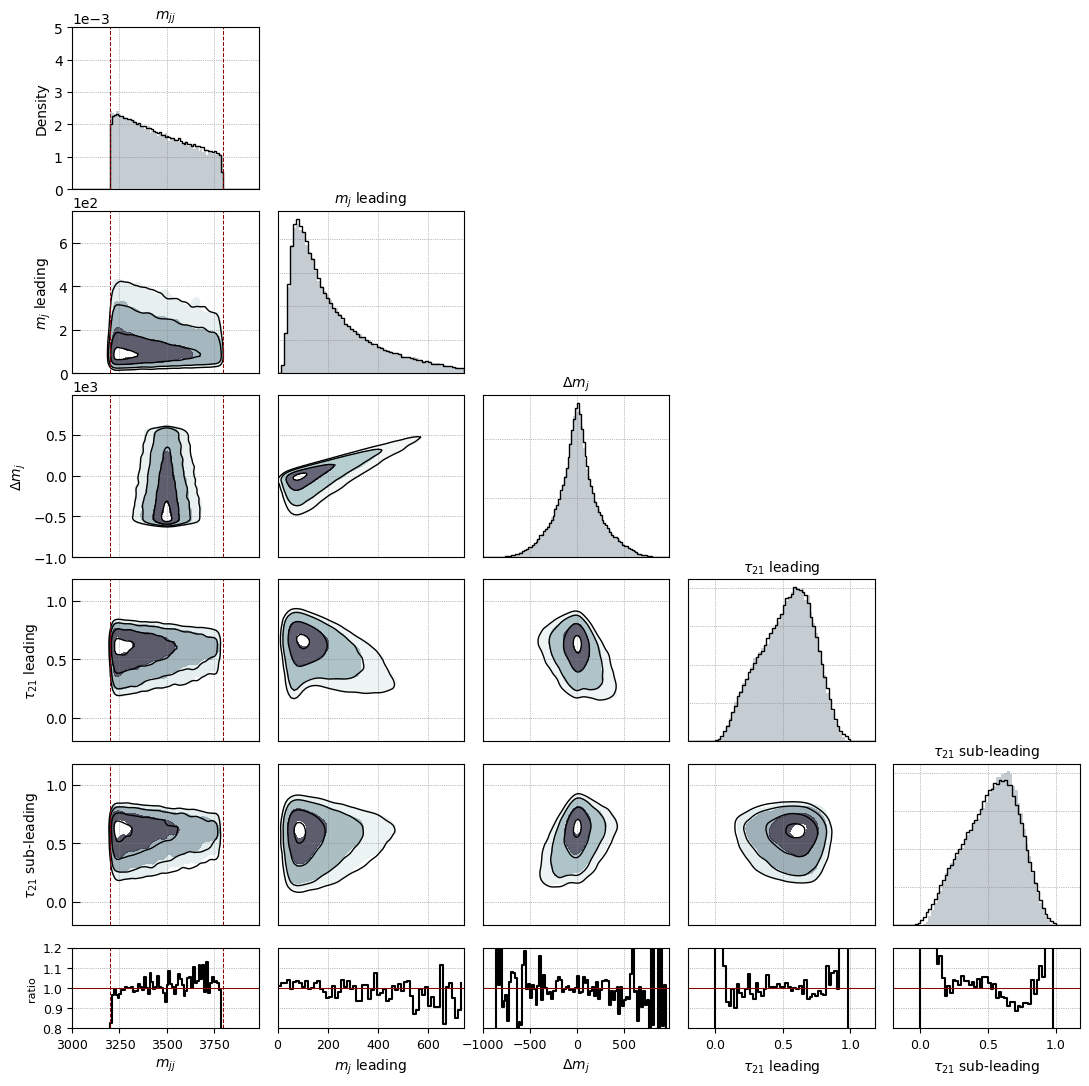

$t_f=$0.49799999594688416, $t_b=0.503000020980835$


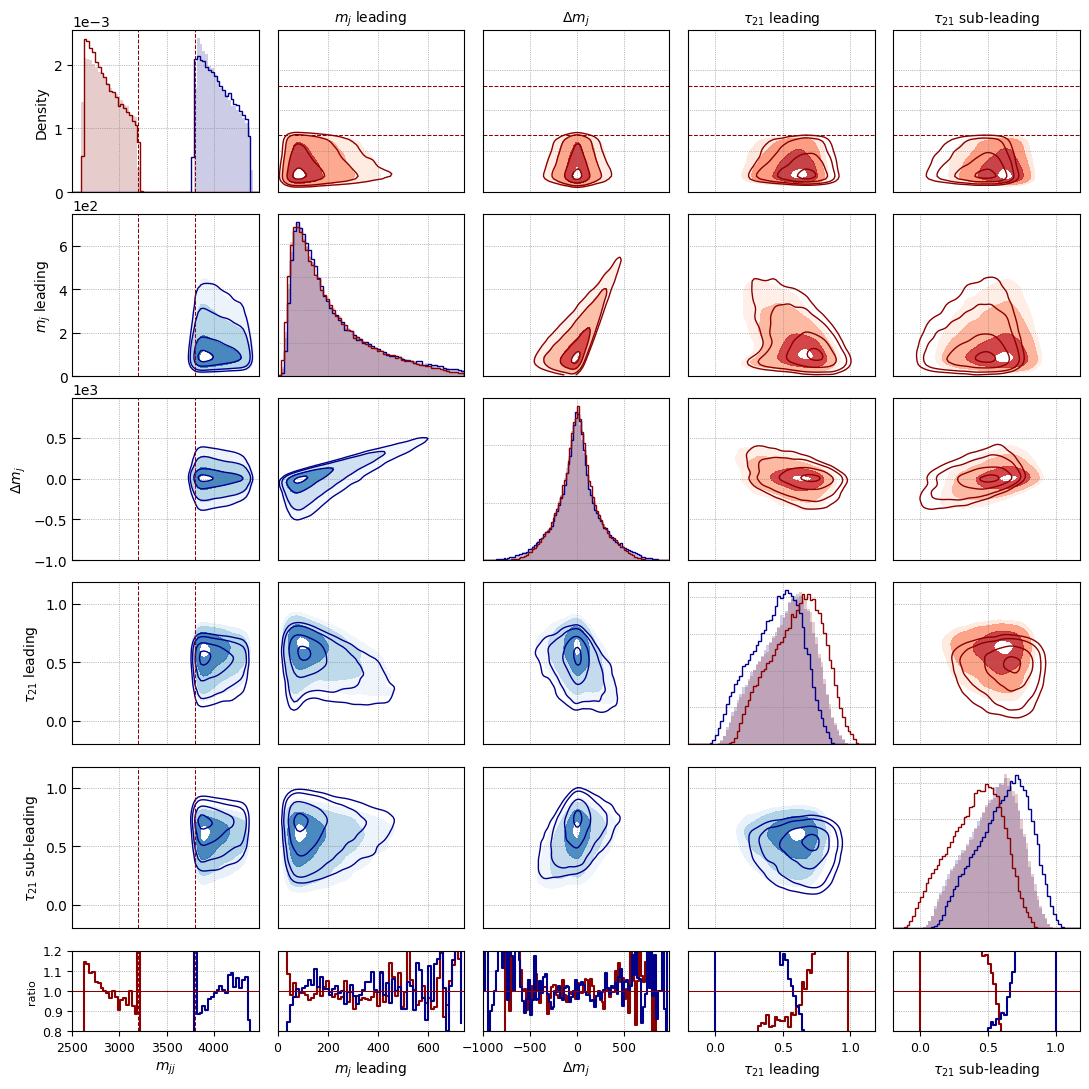

In [3]:
from utils import load_bridge_pipelines
from DynGenModels.dynamics.cnf.condflowmatch import SchrodingerBridgeFlowMatching

model_fwd = '../../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_forward.2023.11.11_22h21'
model_bwd = '../../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_backward.2023.11.11_23h44'

pipe_fwd, pipe_bwd, lhco_fwd, lhco_bwd = load_bridge_pipelines(model_fwd, 
                                                               model_bwd, 
                                                               bridge=SchrodingerBridgeFlowMatching, 
                                                               device='cuda:2')

from utils import plot_interpolation_combined_corner, plot_marginal_fits_corner

plot_interpolation_combined_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                            mass_window=[3200, 3800], 
                            bins=[(3000, 4000, 10), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                            log=False, 
                            density=True,
                            save_path_fwd=model_fwd + '/interpolation_corner_plot.pdf',
                            save_path_bwd=model_bwd + '/interpolation_corner_plot.pdf')

plot_marginal_fits_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                            mass_window=[3200, 3800], 
                            bins=[(2500, 4500, 30), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                            log=False, 
                            density=True,
                            save_path_fwd=model_fwd + '/marginals_corner_plots.pdf',
                            save_path_bwd=model_bwd + '/marginals_corner_plots.pdf')

$t_f=$0.47999998927116394, $t_b=0.5180000066757202$


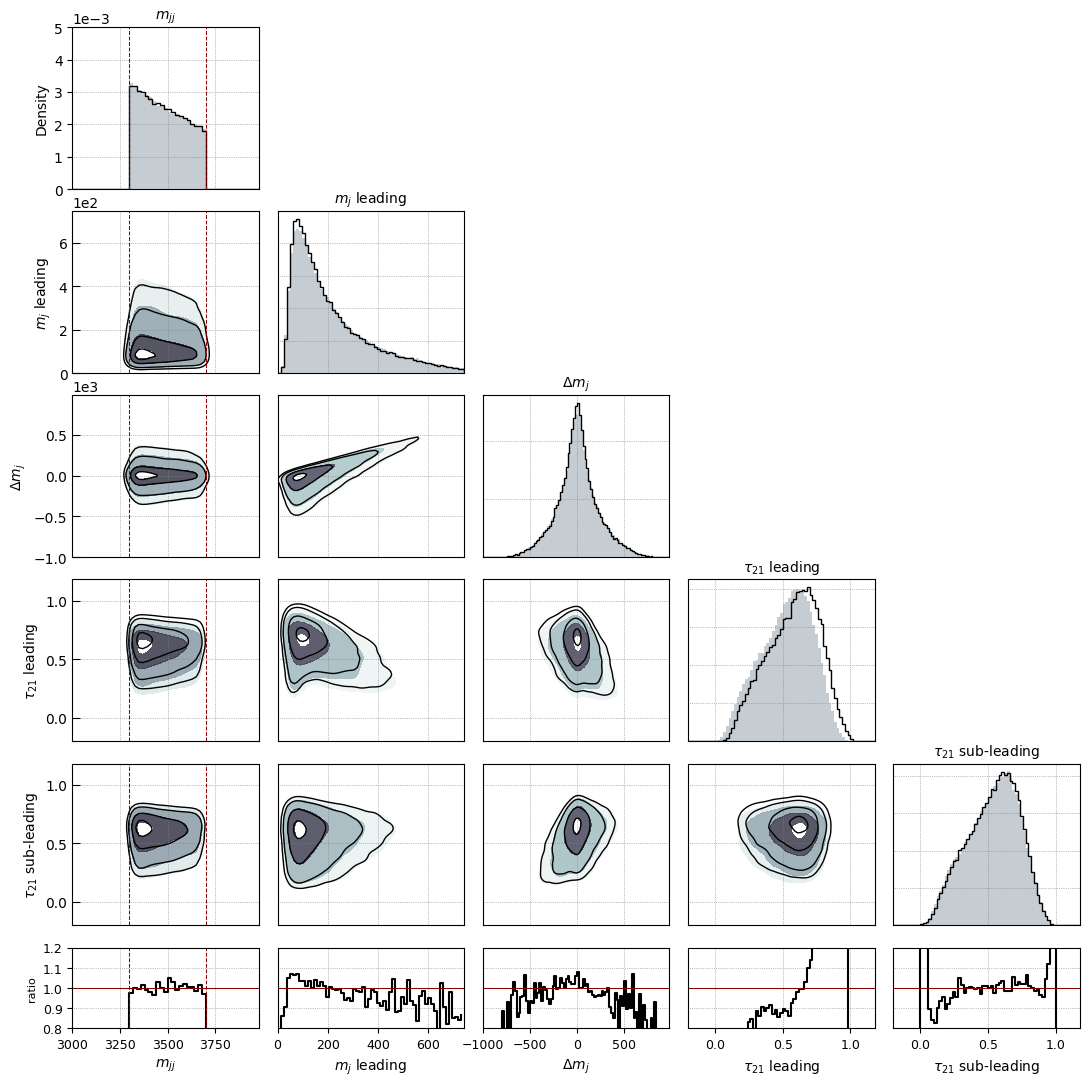

$t_f=$0.47999998927116394, $t_b=0.5180000066757202$


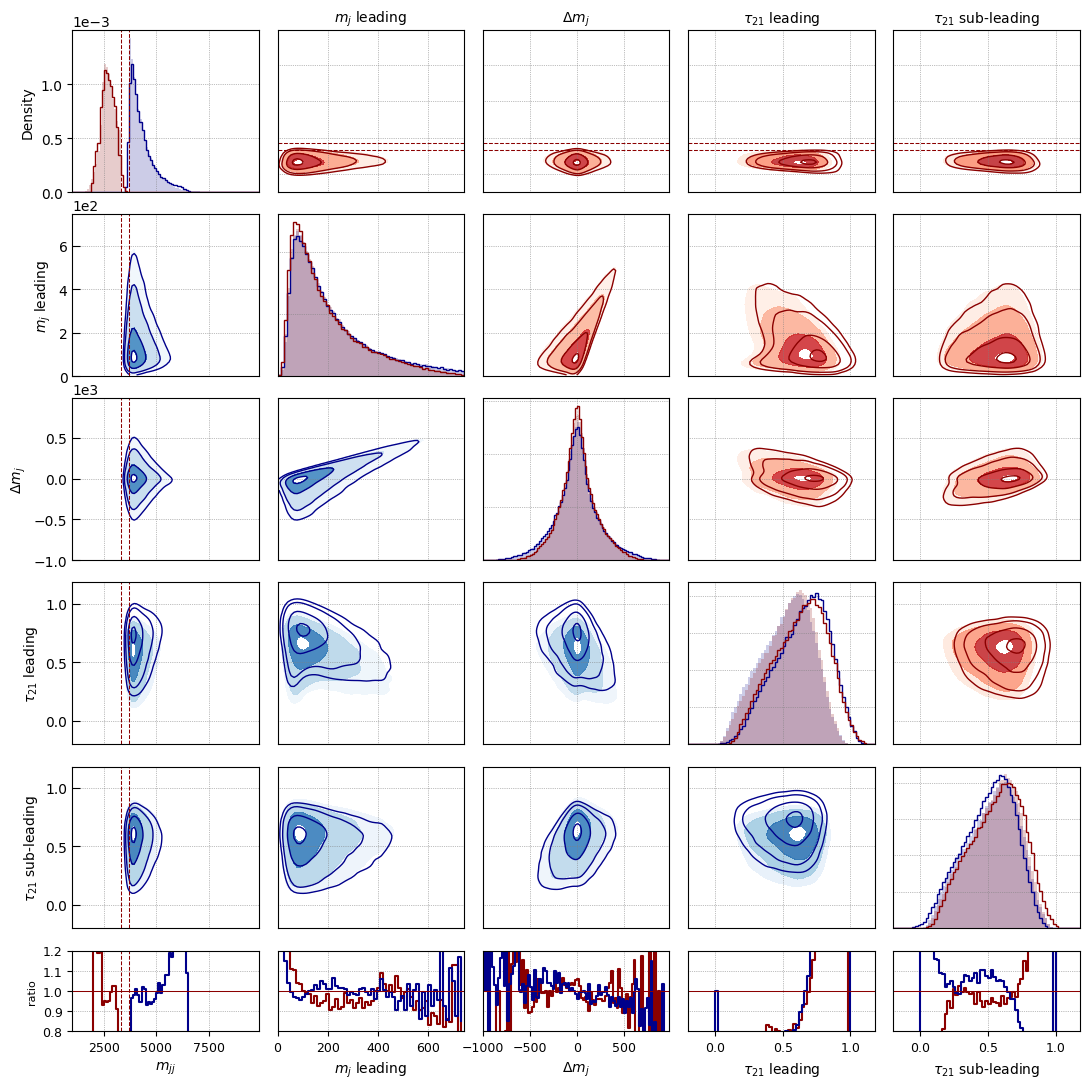

In [2]:
from utils import load_bridge_pipelines
from DynGenModels.dynamics.cnf.condflowmatch import SchrodingerBridgeFlowMatching

model_fwd = '../../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_forward.2023.11.12_05h05'
model_bwd = '../../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_backward.2023.11.12_17h50'

pipe_fwd, pipe_bwd, lhco_fwd, lhco_bwd = load_bridge_pipelines(model_fwd, 
                                                               model_bwd, 
                                                               bridge=SchrodingerBridgeFlowMatching, 
                                                               device='cuda:2')

from utils import plot_interpolation_combined_corner, plot_marginal_fits_corner

plot_interpolation_combined_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                            mass_window=[3300, 3700], 
                            bins=[(3000, 4000, 20), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                            log=False, 
                            density=True,
                            save_path_fwd=model_fwd + '/interpolation_corner_plot.pdf',
                            save_path_bwd=model_bwd + '/interpolation_corner_plot.pdf')

plot_marginal_fits_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                            mass_window=[3300, 3700], 
                            bins=[(1000, 6000, 100), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                            log=False, 
                            density=True,
                            save_path_fwd=model_fwd + '/marginals_corner_plots.pdf',
                            save_path_bwd=model_bwd + '/marginals_corner_plots.pdf')

$t_f=$0.3240000009536743, $t_b=0.6850000023841858$


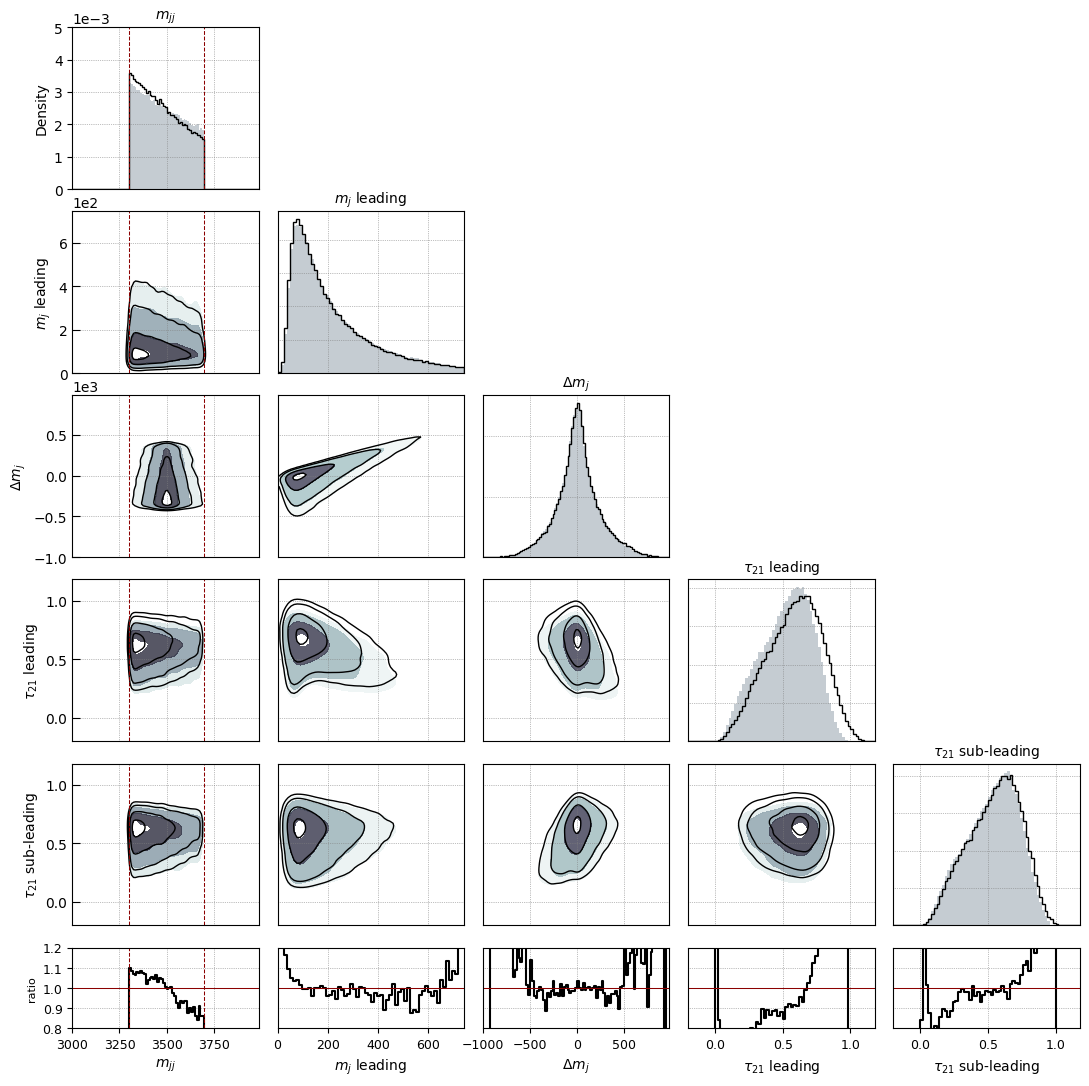

$t_f=$0.3240000009536743, $t_b=0.6850000023841858$


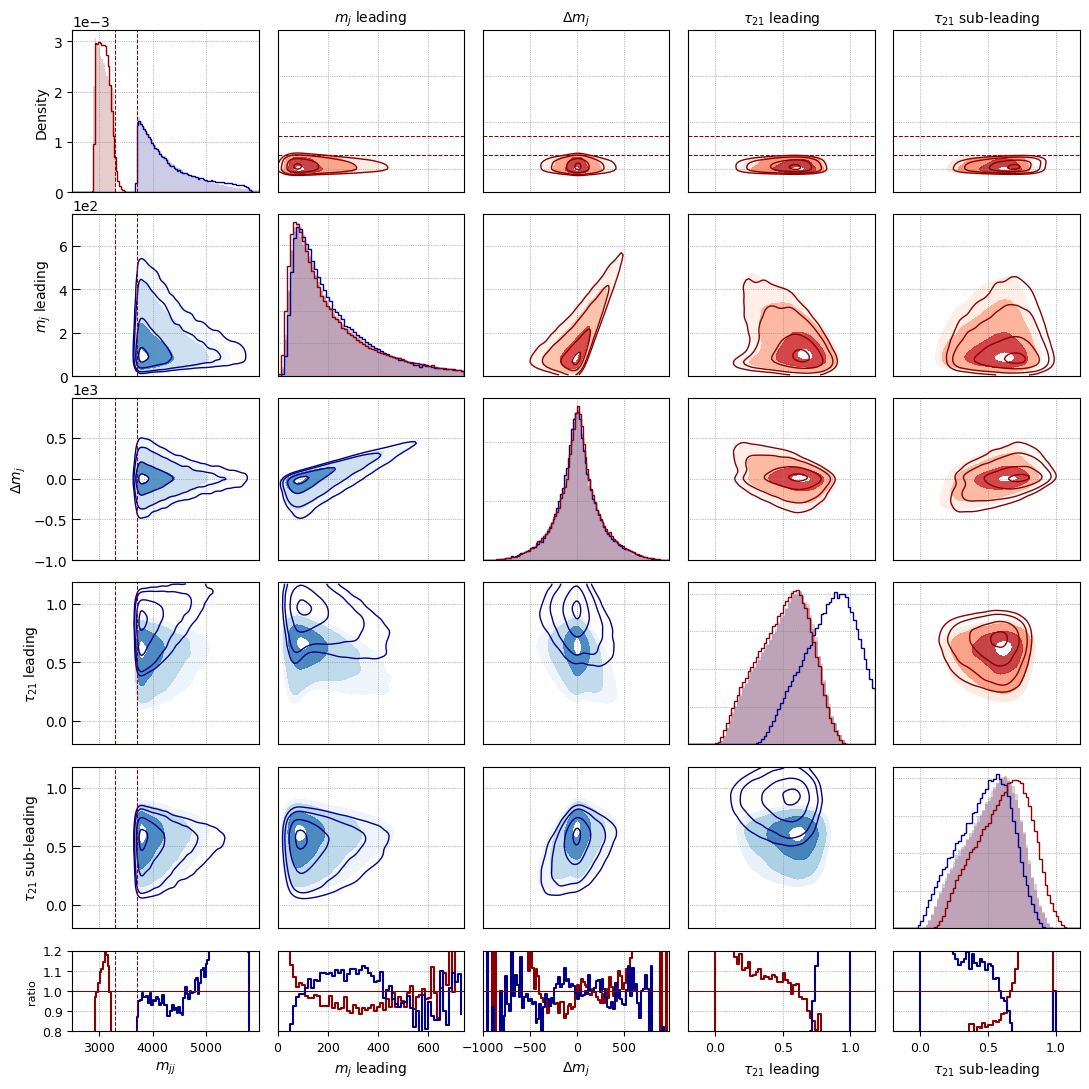

In [7]:
from utils import load_bridge_pipelines
from DynGenModels.dynamics.cnf.condflowmatch import SchrodingerBridgeFlowMatching

model_fwd = '../../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_forward.2023.11.12_21h02'
model_bwd = '../../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_backward.2023.11.12_07h08'

pipe_fwd, pipe_bwd, lhco_fwd, lhco_bwd = load_bridge_pipelines(model_fwd, 
                                                               model_bwd, 
                                                               bridge=SchrodingerBridgeFlowMatching, 
                                                               device='cuda:2')

# from utils import plot_interpolation_combined_corner, plot_marginal_fits_corner

plot_interpolation_combined_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                            mass_window=[3300, 3700], 
                            bins=[(3000, 4000, 10), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                            log=False, 
                            density=True,
                            save_path_fwd=model_fwd + '/interpolation_corner_plot.pdf',
                            save_path_bwd=model_bwd + '/interpolation_corner_plot.pdf')

plot_marginal_fits_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                            mass_window=[3300, 3700], 
                            bins=[(2500, 6000, 30), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                            log=False, 
                            density=True,
                            save_path_fwd=model_fwd + '/marginals_corner_plots.pdf',
                            save_path_bwd=model_bwd + '/marginals_corner_plots.pdf')

$t_f=$0.49300000071525574, $t_b=0.5040000081062317$


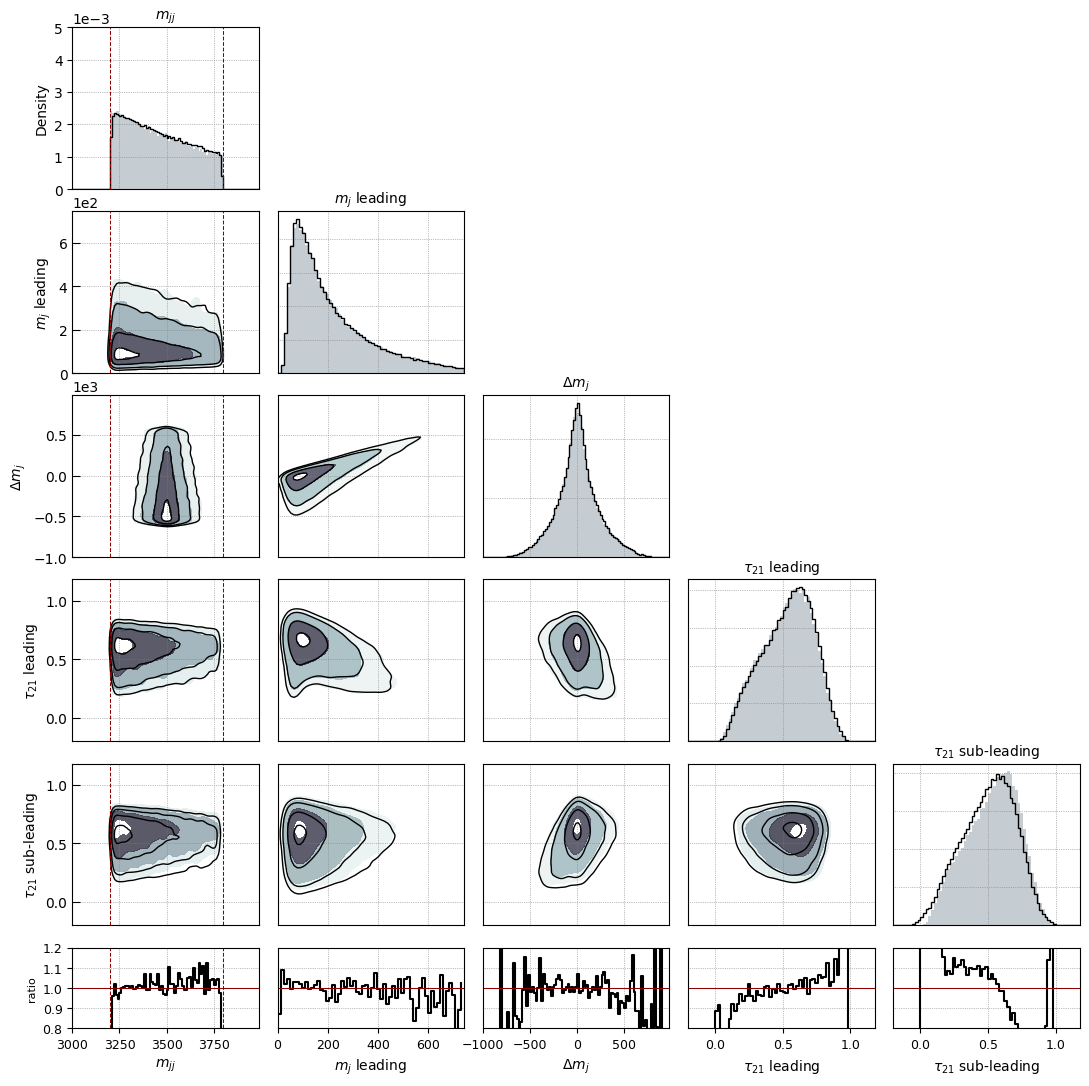

$t_f=$0.49300000071525574, $t_b=0.5040000081062317$


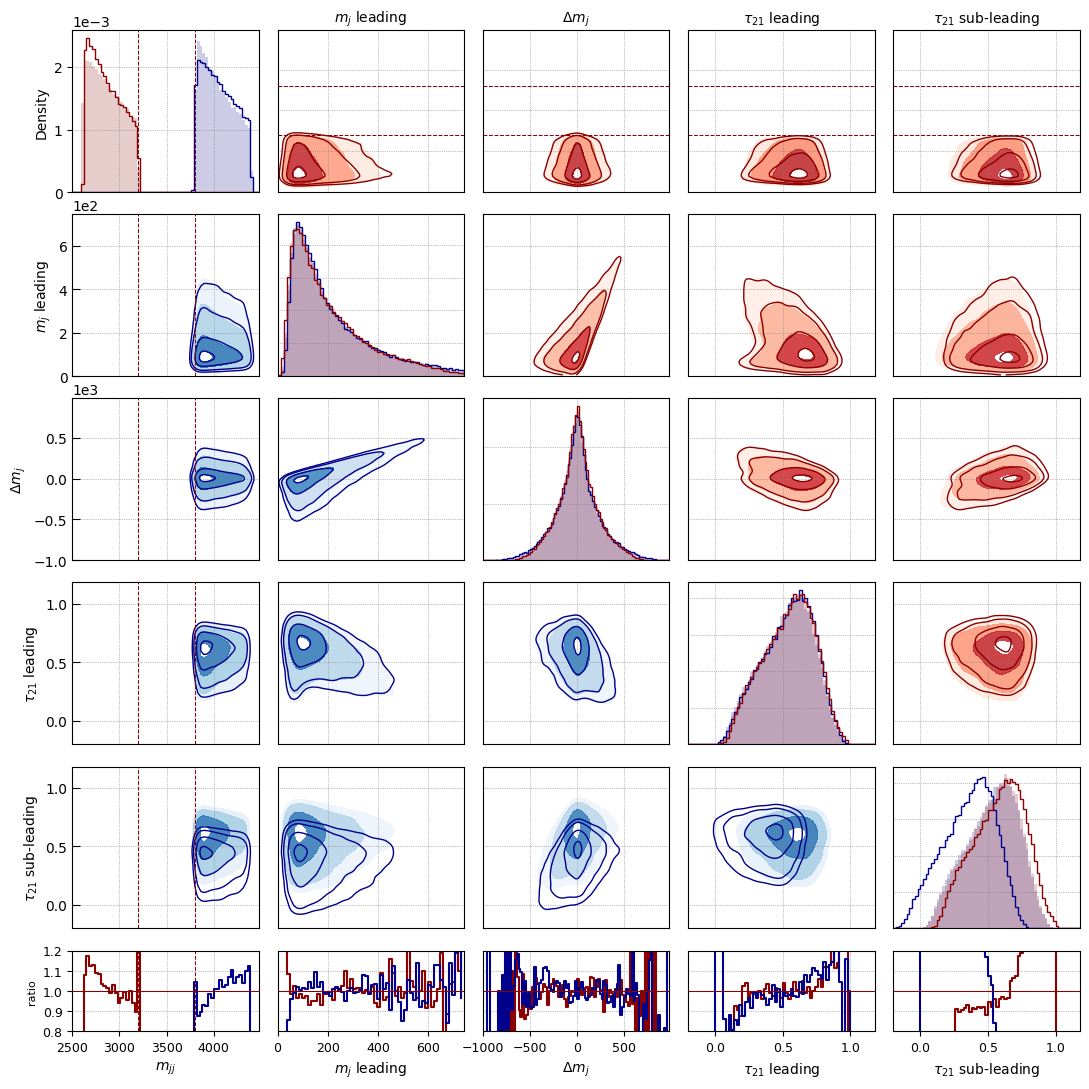

In [3]:
# sigma=0.1

# from utils import load_bridge_pipelines
# from DynGenModels.dynamics.cnf.condflowmatch import SchrodingerBridgeFlowMatching

# model_fwd = '../../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_forward.2023.11.12_17h50'
# model_bwd = '../../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_backward.2023.11.12_19h47'

# pipe_fwd, pipe_bwd, lhco_fwd, lhco_bwd = load_bridge_pipelines(model_fwd, 
#                                                                model_bwd, 
#                                                                bridge=SchrodingerBridgeFlowMatching, 
#                                                                device='cuda:2')

from utils import plot_interpolation_combined_corner, plot_marginal_fits_corner

plot_interpolation_combined_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                                    mass_window=[3200, 3800], 
                                    bins=[(3000, 4000, 10), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                                    log=False, 
                                    density=True,
                                    save_path_fwd=model_fwd + '/interpolation_corner_plot.pdf',
                                    save_path_bwd=model_bwd + '/interpolation_corner_plot.pdf')

plot_marginal_fits_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                            mass_window=[3200, 3800], 
                            bins=[(2500, 4500, 30), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                            log=False, 
                            density=True,
                            save_path_fwd=model_fwd + '/marginals_corner_plots.pdf',
                            save_path_bwd=model_bwd + '/marginals_corner_plots.pdf')